**Initial notebook for RSNA-MICCAI Brain Tumor Radiogenomic Classification**

for free further use & utilization & modification.

This is a notebook including essential parts for the RSNA -competition in special practical "data and neural network model in your fingertips" -sense. The notebook is in a "quick & dirty" -format, including only the basic "skeleton" for the analysis & modelling, not optimized or showing direct ways to obtain high accuracy. 

But, the notebook include several lines or part of code (by removing comments or the like) which allow you to monitor and see practically how does the data look like and behave and so on. Especially, the notebook may include some tricks or ideas (comments in the code in Finnish ... may need some explanation) which may be beneficial. The idea of the notebook there is the following:

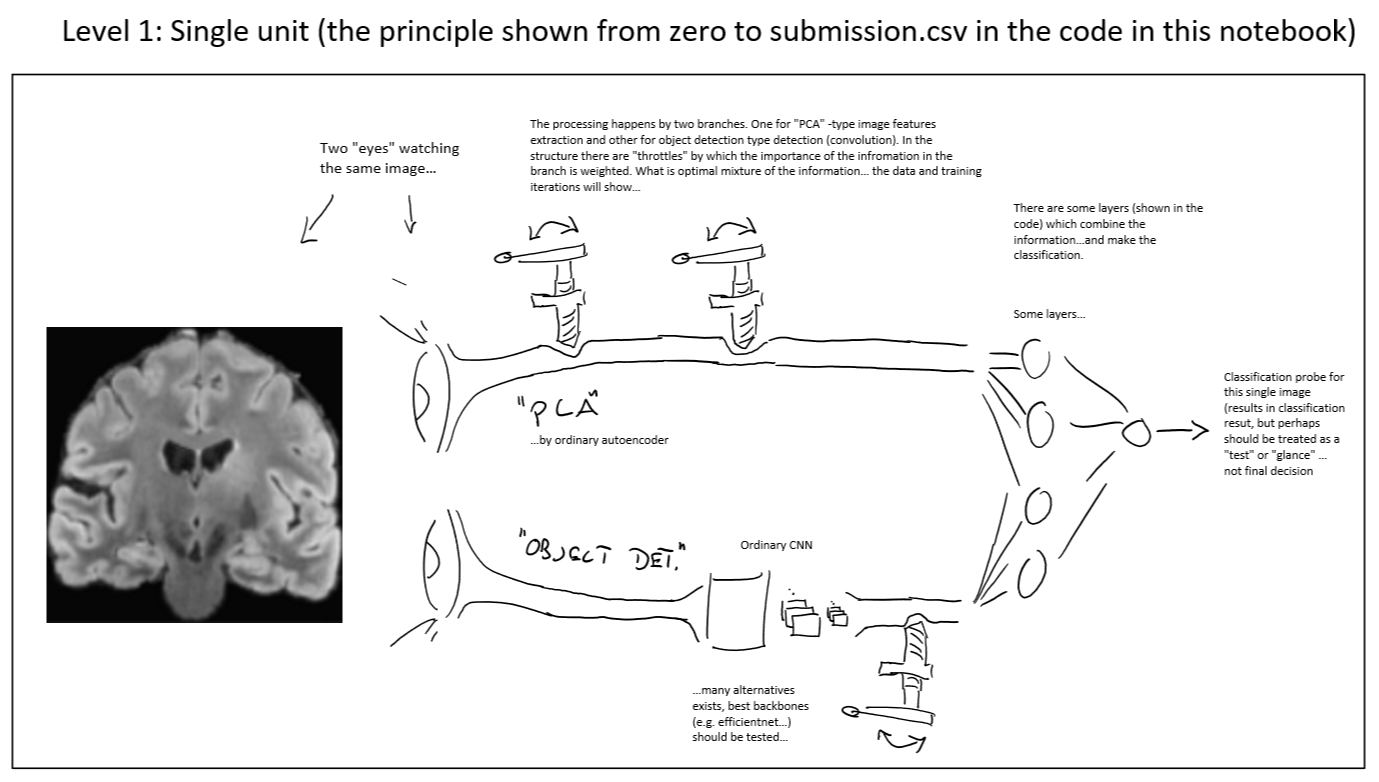

The idea in the picture above is implemented in this notebook. By training the data with a small set (using prosessitesti=1 selected) you are able to understand importance of the two branches of information - when the training begins to learn rapidly, when it will overfit, etc. This phase helps you to understand the dynamics and underastandig of "plasticity" of the data and analysis. After this phase - meaning high increas in understanding the data "in your fingertips" the possible next steps are that after enough polishing the structure of "Level 1" the next (and easy-to-implement) level directly would be:

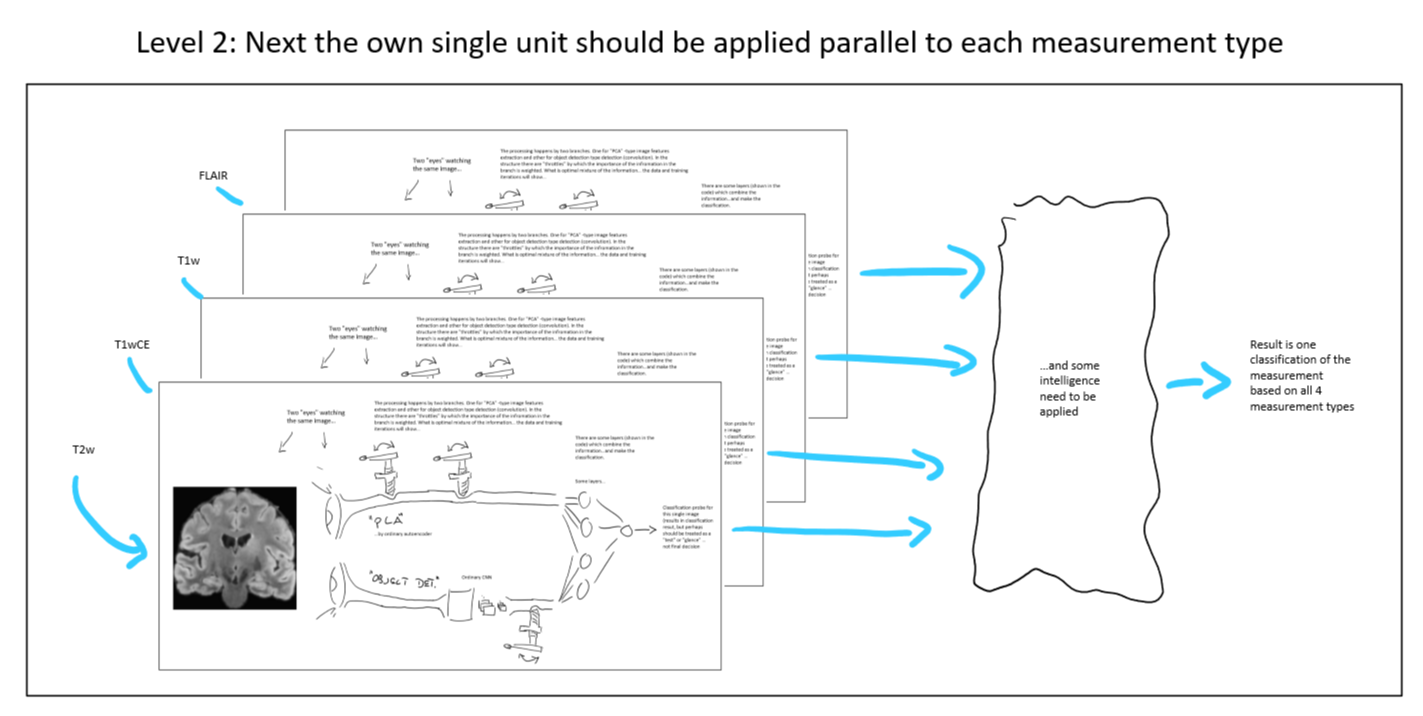

...and after using some flops and sweat to obtain all performance out from that Level 2-phase next also the time domain of the data should utilized in full format...

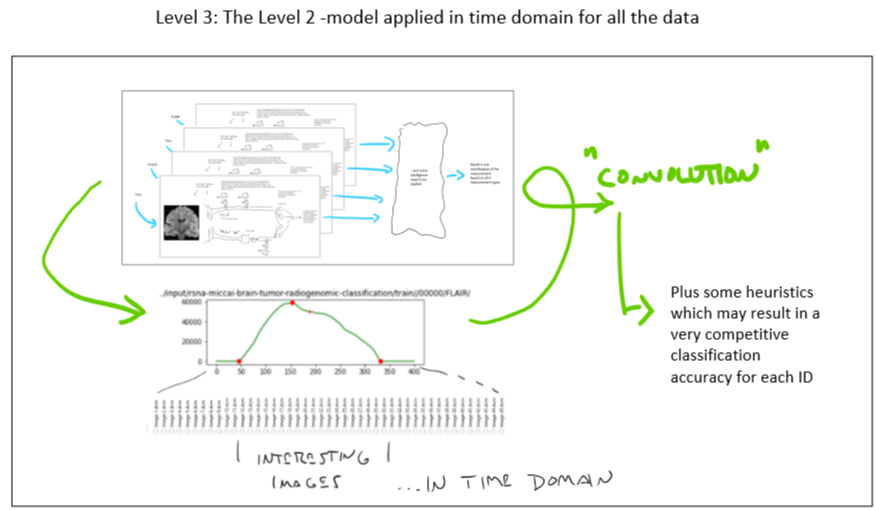

...including some extra intellingence always before doing "final" decision of MGMT for each ID in the data. The utilization of the time-domain is a longer story and affects a lot for the final score, but by wisely creating and managing phase 1 & phase 2 blocks it may be possible to efficiently find some special advantage from this final level of the analysis like a "extra orthogonal dimension" to increase the classification accuracy after all other useful information has been fully utilized.

ZZZZZZZZ

ZZZZZ

ZZZ

ZZ

**I'm sorry, maybe you fell asleep during this looong story, thus let's keep it simple: click "Run All" and then see the pictures and results and so on, and this way you see what is the question about!**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session"


print("Aloitetaanpa...")

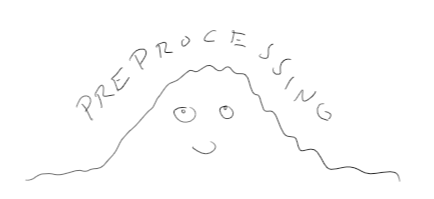
...let's make some preprocessing for the training data:

In [ ]:
#*******************************
#
# Tehdaan valintoja sen mukaan halutaanko ajaa koko prosessi lapi nopeasti ja pienella aineistolla (prosessitesti=1 tai enemman....)
# vai ajetaanko koko prosessi lapi ihan kaikella aineistolla (prosessitesti=0)

prosessitesti=1

# ...so if you select the value above as prosessitesti=1 only small part of the data will be used in the analysis, 
# meaning the whole preprocessing - network training will take only time for "one cup of coffee". This is useful when investigating the data features and molding the 
# structure of the network.
#
# ...but when you want to go throught the whole data (required for the submission...) then select prosessitesti=0, but it will take more time (hour or two or like)

In [ ]:
print("Opetusaineiston esikasittely....")
import cv2
import os
import pydicom
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import math

t_alku=time.time()

peruspolku="../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/"
tyyppi=("FLAIR", "T1w", "T1wCE", "T2w")
#tama liittyy kuvan esikasittelyyn:
kuvakoko=128 #256
#ja neuroverkon kuvakoko on sitten asia erikseen...

def analysoi_yhden_kansion_kuvapinon_piirteet(inputdir,nayta):
    global kuvakoko
    #haetaan tiedostonimet
    test_list=[f for f in os.listdir(inputdir)]
    #jarjestetaan kuvanumeron mukaan:
    test_list_s=sorted(test_list, key=lambda x: int(x[:-4].split("-")[-1]))

    #kuvakoko=128
    kuvasumma=[]
    kaytossa_olevat_pikselit=[]
    kierros=0
    for f in test_list_s:
        ds=pydicom.read_file(inputdir+f)
        img=ds.pixel_array
        #tehdaan analyysia kuvasta ajan suhteen...
        #kuvasumma.append(sum(sum(np.abs(img))))
        kaytossa_olevat_pikselit.append(np.argwhere(img>0).shape[0])
        kierros=kierros+1

    #etsitaan pikselipolttokayrasta edustavat pisteet...
    maksimikohta_p=np.argmax(kaytossa_olevat_pikselit)

    #ensimmainen nollanylitys vasemmalta:
    nollaa_isommat_p=np.nonzero(kaytossa_olevat_pikselit)
    alkukohta_p=nollaa_isommat_p[0][:][0]
    loppukohta_p=nollaa_isommat_p[0][-1:][0]
    laskennallinen_puolivali_p=np.int((alkukohta_p+loppukohta_p)/2)

    ennen_p=alkukohta_p #maksimikohta-10 tyyliin....
    jalkeen_p=loppukohta_p #maksimikohta+10 tyyliin...
 
    #lasketaan pisteet mitka ovat alkupisteen ja huippupisteen puolestavalista...
    alkupuoli_p=np.int(np.round((ennen_p+maksimikohta_p)/2))
    loppupuoli_p=np.int(np.round((jalkeen_p+maksimikohta_p)/2))                

    if nayta==1:
        plt.subplot(2,1,2)
        plt.plot(kaytossa_olevat_pikselit,'g')
        plt.plot(maksimikohta_p,kaytossa_olevat_pikselit[maksimikohta_p],'ro')
        plt.plot(ennen_p,kaytossa_olevat_pikselit[ennen_p],'bo')
        plt.plot(jalkeen_p,kaytossa_olevat_pikselit[jalkeen_p],'bo')
        plt.plot(laskennallinen_puolivali_p,kaytossa_olevat_pikselit[laskennallinen_puolivali_p],'r+')
        plt.plot(alkupuoli_p,kaytossa_olevat_pikselit[alkupuoli_p],'ro')
        plt.plot(loppupuoli_p,kaytossa_olevat_pikselit[loppupuoli_p],'ro')      
        plt.title(inputdir)
        plt.draw()
        plt.pause(2.5)
        plt.clf()
        #plt.show()

    #palautetaan ne ideksit, joissa sijaitsee kiinnostavat kuvat:
    return test_list_s[maksimikohta_p],test_list_s[laskennallinen_puolivali_p],test_list_s[alkupuoli_p],test_list_s[loppupuoli_p]

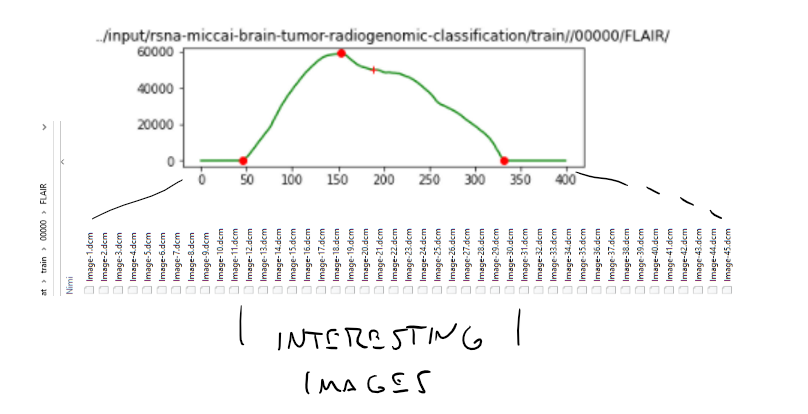

...it may be useful to explore the time domain content of the images in each folder, the idea shown in the example image above; in each folder there is a number of images. The profile of the images follows the measurement process (magnetic pulse...) and there is possibilities to monitor this input - output characteristics, and make wise selections for the input data on this basis. Thus, the question is not about 3d cnn, but something else...

In [ ]:
#taman avulla voi esimerkinomaisesti tulostaa yhden kansion ominaispiirteita...

inputdir_esim=peruspolku+'/00000/FLAIR/'
analysoi_yhden_kansion_kuvapinon_piirteet(inputdir_esim,1)

#...oikein on kysymys, sita on hyva hiukan pyoritella...

In [ ]:
#Määritellään silmukka, joka käy läpi kuvia...
id_numero=0
tyyppi_numero=0

#Esimerkki polusta:
#inputdir='C:/Users/manne/aivokuvat/train/00006/FLAIR/'

train_df = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
#opetuksen_id_luettelo=np.array([106,107]) #list(range(0,1)) #np.array(train_df["BraTS21ID"])

#poistetaan tehtavanannossakin mainitut ongelmatapaukset...
EXCLUDE = [109, 123, 709]
train_df = train_df[~train_df.BraTS21ID.isin(EXCLUDE)]


if prosessitesti==1:
    #lyhenna testeissa...muutoin jata hakasulkeet lopusta pois kokonaan!
    opetuksen_id_luettelo=np.array(train_df["BraTS21ID"])[0:50]
    opetuksen_vasteet=np.array(train_df["MGMT_value"])[0:50]
else:
    opetuksen_id_luettelo=np.array(train_df["BraTS21ID"])
    opetuksen_vasteet=np.array(train_df["MGMT_value"])    

opetus_syote=[]
opetus_syote_0=[]
opetus_syote_1=[]
opetus_syote_2=[]
opetus_syote_3=[]

opetus_vaste=[]
kierros=0

print("*************************************")
print("Aloitetaan id-luettelon lapikaynti...")

def yhden_kuvan_kasittely(hakupolku,kuvakoko):

    #naytetaan tama kuva:
    ds_1=pydicom.read_file(hakupolku)
    img_1=ds_1.pixel_array

    #samalla skaalataan "yleisen ohjeen" mukaan:
    if np.min(img_1)<np.max(img_1):
        img_1=img_1-np.min(img_1)
        img_1=img_1/np.max(img_1)

    #valitaan vain ei-musta alue:
    vaaka=np.sum(img_1,axis=0)
    #ensimmainen ei-nolla-arvo vaakasta...
    nollaa_isommat_vaaka=np.nonzero(vaaka)
    alkukohta_vaaka=nollaa_isommat_vaaka[0][:][0]
    loppukohta_vaaka=nollaa_isommat_vaaka[0][-1:][0]

    pysty=np.sum(img_1,axis=1)
    nollaa_isommat_pysty=np.nonzero(pysty)
    alkukohta_pysty=nollaa_isommat_pysty[0][:][0]
    loppukohta_pysty=nollaa_isommat_pysty[0][-1:][0]

    #valitaan kuvaksi vain ko. alue...
    img_1=img_1[alkukohta_pysty:loppukohta_pysty,alkukohta_vaaka:loppukohta_vaaka]

    #varmistetaan etta kuvakoko on kaikille sama, muutoin tulee ongelmia!
    img_1=cv2.resize(img_1,dsize=(kuvakoko,kuvakoko),interpolation=cv2.INTER_CUBIC)
    return img_1



for id_numero in opetuksen_id_luettelo:
    kierros=kierros+1


    tyyppi_lippu=0
    for tyyppi_numero in range(4):
        try:
            inputdir=''.join([peruspolku,str(id_numero).zfill(5),"/",tyyppi[tyyppi_numero],"/"])
            #aika1=time.time()
            [maksimikohta_p,laskennallinen_puolivali_p,alkupuoli_p,loppupuoli_p]=analysoi_yhden_kansion_kuvapinon_piirteet(inputdir,0)
            #print("Hakuun kului...",time.time()-aika1," sekuntia")
    
            hakupolku=inputdir+maksimikohta_p
            maksimikohta_p_img=yhden_kuvan_kasittely(hakupolku,kuvakoko)
            
            hakupolku=inputdir+laskennallinen_puolivali_p
            laskennallinen_puolivali_p_img=yhden_kuvan_kasittely(hakupolku,kuvakoko)
            
            hakupolku=inputdir+alkupuoli_p
            alkupuoli_p_img=yhden_kuvan_kasittely(hakupolku,kuvakoko)
            
            hakupolku=inputdir+loppupuoli_p
            loppupuoli_p_img=yhden_kuvan_kasittely(hakupolku,kuvakoko)
          
            if 0:
                plt.subplot(2,1,1)
                plt.imshow(img_1)
                #plt.subplot(2,1,2)
                #plt.imshow(img_2)

                plt.draw()
                plt.pause(0.2)
                plt.clf()
                #plt.show()
         
            #vaihtoehto on etta tehdaan oma kuva jokaisesta!
            opetus_syote.append(maksimikohta_p_img)
            opetus_syote.append(laskennallinen_puolivali_p_img)
            opetus_syote.append(alkupuoli_p_img)
            opetus_syote.append(alkupuoli_p_img)
            
            vastearvo=opetuksen_vasteet[kierros-1]
            #ja jokaista vastaava vasteindeksi tallennetaan samalla vauhdilla...
            opetus_vaste.append(vastearvo)
            opetus_vaste.append(vastearvo)
            opetus_vaste.append(vastearvo)
            opetus_vaste.append(vastearvo)
                
            if 0:
                plt.imshow(isokuva) #,cmap='gray', vmin=0, vmax=1)
                plt.title(''.join(["ID:n ",str(id_numero)," kaikki piirrekuvat, vaste: ",str(vastearvo)]))
                plt.draw()
                #print(np.max(isokuva))
                plt.pause(0.5)

            #print("ID-numeroa ",id_numero," vastaava vastearvo: ",vastearvo)
        
        except:
            print("aineistossa puutteita!")
        if kierros==1:
            print("...tsippa...dippa...duu...")
            
            
    if np.mod(kierros,10)==0:
        print("Kasittelysta noin ",100*kierros/len(opetuksen_id_luettelo)," % valmiina...")

print("...silmukka valmis!")


#Tutkitaan histogrammia...

#Loop tekee listaa...sen vuoksi muutetaan arrayksi:
#opetus_syote_2=np.array(opetus_syote)

opetus_syote_2=np.array(opetus_syote)

opetus_vaste_2=np.array(opetus_vaste)

#muutetaan muotoa ... värin huomiointi...huomaa muuttaa viimeinen numero sen mukaan mika tilanne...
opetus_syote_3=np.reshape(opetus_syote_2,(opetus_syote_2.shape[0],opetus_syote_2.shape[1],opetus_syote_2.shape[2],1))

opetus_vaste_3=opetus_vaste_2

#print("opetus_syote_3.shape on: ",opetus_syote_3.shape)

#muunnetaan vaste luokkavektoriksi:
opetus_vaste_4k=np.zeros((len(opetus_vaste_3),2))
for i in range(len(opetus_vaste_4k)):
    if opetus_vaste_3[i]==0:
        opetus_vaste_4k[i][0]=1
    else:
        opetus_vaste_4k[i][1]=1

#jaetaan aineisto opetus- ja validointiaineistoon (erotukseksi testiaineistosta joka on sitten omansa...)
indeksit_kaikki=list(range(0,len(opetus_vaste_4k)))
#print("indeksit_kaikki pituus on: ",len(indeksit_kaikki))
indeksit_opetus=[]
indeksit_validointi=[]
for i in range(len(indeksit_kaikki)):
    #maarataan 80% opetusaineistoon, loput validointiin...
    if i<0.8*len(indeksit_kaikki):
        indeksit_opetus.append(i)
    else:
        indeksit_validointi.append(i)

print("Datasetti valmis!")

opetus_syote_4=opetus_syote_3[indeksit_opetus][:][:][:]

opetus_vaste_4=opetus_vaste_4k[indeksit_opetus][:]

try:
    validointi_syote_4=opetus_syote_3[indeksit_validointi][:][:][:]

    validointi_vaste_4=opetus_vaste_4k[indeksit_validointi][:]
except:
    validointi_syote_4=0
    validointi_vaste_4=0

print("Opetus- ja validointiaineisto jaettu!")

#näytetään tulos:
print("Opetustiedon 0 muoto: ", opetus_syote_4.shape)
print("Opetuksen vastetiedon muoto: ", opetus_vaste_4.shape)

print("Validointitiedon 0 muoto: ", validointi_syote_4.shape)
print("Validoinnin vastetiedon muoto: ", validointi_vaste_4.shape)

#tallennetaan tiedot:
#luodaan tiedosto
f_opetus=open('opetustiedot.pckl','wb')
#f_testi=open('testitiedot.pckl','wb')

#tallennellaan jotta koeversiota on nopea varioida...
pickle.dump([opetus_syote_4,opetus_vaste_4,validointi_syote_4,validointi_vaste_4],f_opetus)
print("...dumpattu!")
f_opetus.close()
print("Opetus- ja validointiaineisto tallennettu!!")

#ennen skaalauksia:

arvot=opetus_syote_4.flatten()
plt.subplot(1,1,1)
plt.hist(arvot[arvot>0],bins=100)
plt.title('opetus_syote -kuvajoukon jakauma')

plt.show()

print("Kaikki valmista, kesto oli: ",time.time()-t_alku," sekuntia.")
print("************************************************************")

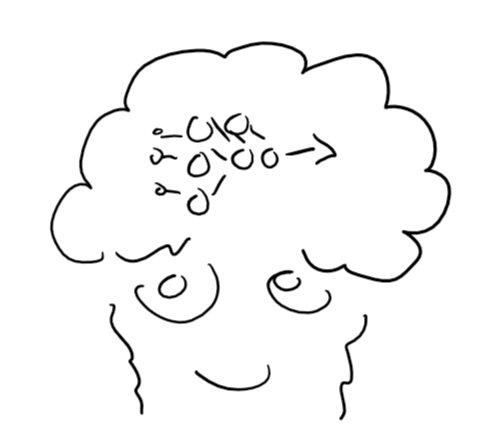

...creating & training the network:

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import os

#########################################################
#
# Tarkeimmat opetusparametrit:
#
# Resoluutio, joka syotetaan neuroverkolle:
IMG_SIZE=256 #2*kuvakoko
#Montako opetuskierrosta tehdaan:
epochs=50
#
#
#########################################################

t_alku=time.time()

if 0:

    peukalopolku='../input/aivo-v/'
    peukalopolku='/kaggle/working/'

    #pikaladataan tiedot picklella....lisaa tahan sitten kun....
    try:
        peukalopolku='../input/aivo-v/'
        varasto=pickle.load(open(peukalopolku+'opetustiedot.pckl',"rb"))
        print("Tiedot ladattu internet-yhteydella")
    except:
        peukalopolku='/kaggle/working/'
        varasto=pickle.load(open(peukalopolku+'opetustiedot.pckl',"rb"))
        print("Tiedot ladattu paikallisesti")

#ladataan nykyisesta tyoskentelypolusta:
#varasto=pickle.load(open('opetustiedot.pckl',"rb"))
#varasto=pickle.load(open('../input/aivo-v/opetustiedot.pckl',"rb"))
#[opetus_syote_4_0,opetus_syote_4_1,opetus_syote_4_2,opetus_syote_4_3,opetus_vaste_4,validointi_syote_4_0,validointi_syote_4_1,validointi_syote_4_2,validointi_syote_4_3,validointi_vaste_4]=varasto
#print("Tiedot ladattu paikallisesti")

#
#
# Pippurointi!
#
#

if 0:

    #verkon muovailemiseksi (loydetaan nopeasti oppiva pohjamalli...) lisataan pippurointitapla kaikkiin syotetapauksiin missa vaste on yksi...
    print("Lisataan opetustaplat...")
    kpl=0
    taplan_koko=5
    for i in range(opetus_vaste_4.shape[0]):
        satunnais_sijainti_lev=np.random.randint(10,100)
        satunnais_sijainti_kork=np.random.randint(10,100)
        if opetus_vaste_4[i][1]==1:
            opetus_syote_4_0[i][satunnais_sijainti_kork:(satunnais_sijainti_kork+taplan_koko),satunnais_sijainti_lev:(satunnais_sijainti_lev+taplan_koko)]=0.9
            kpl=kpl+1

    print("...lisatty ",kpl, " opetustaplaa!")

    kpl=0
    for i in range(validointi_vaste_4.shape[0]):
        satunnais_sijainti_lev=np.random.randint(10,100)
        satunnais_sijainti_kork=np.random.randint(10,100)
        if validointi_vaste_4[i][1]==1:
            validointi_syote_4_0[i][satunnais_sijainti_kork:(satunnais_sijainti_kork+taplan_koko),satunnais_sijainti_lev:(satunnais_sijainti_lev+taplan_koko)]=0.9
            kpl=kpl+1

    print("...lisatty ",kpl, " validointitaplaa!")

    #naytetaan esimerkki pippuroidusta datasta:
    fig0=plt.figure()
    plt.subplot(2,1,1)
    plt.imshow(opetus_syote_4_0[0])
    plt.title("Esimerkki pippuroinnista syote- ja validointiaineistossa...")
    plt.subplot(2,1,2)
    plt.imshow(validointi_syote_4_0[0])
    plt.draw()
    plt.pause(1)


print("Tiedot ladattu ajassa...",time.time()-t_alku)

#Ja tahan oma malli, syotteeksi edelta ko. data, ja tf prosesseilla vain ....
#Jolle perus-tunnistus.
import tensorflow as tf
from tensorflow import keras

#Omaa verkkoa varten...kun ollaan isomman laskentatehon aarella, tata kokoa pitaa kasvattaa...
#IMG_SIZE=128
#IMG_SIZE=64
#IMG_SIZE=32
NUM_CLASSES=2

#Muistetaan että efficientnet voi ottaa sisaan vain ko. kokoista kuvamateriaalia...
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

#lisataan autoencooderi PCA-tyyppista tuumintaa varten...josta on sitten tehokas tehda perusluokitusta...

def enkooderi(syotekuvajoukko):

    input_img = keras.Input(shape=((syotekuvajoukko.shape[1],syotekuvajoukko.shape[2],syotekuvajoukko.shape[3])))
    #input_img = keras.Input(shape=(kuvakoko,kuvakoko,1))

    
    x = layers.Conv2D(6*16, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    #x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # pullonkaula-kohta!

    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    #x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(6*16, (3, 3), activation='relu')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    muuntokerros_auto=tf.keras.layers.experimental.preprocessing.Resizing(syotekuvajoukko.shape[1],syotekuvajoukko.shape[2],interpolation="bilinear")
    decoded=muuntokerros_auto(decoded)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics='accuracy')

    #opetetaan...
    auto_historia=autoencoder.fit(syotekuvajoukko, syotekuvajoukko,
                    epochs=30,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(syotekuvajoukko, syotekuvajoukko),
                                 )
    
    #luodaan erikseen malli, joka tekee tasmalleen edellakuvatun tiivistyksen:
    tiivistaja=keras.Model(input_img,encoded)
    
    fig99=plt.figure()
    plt.plot(auto_historia.history["accuracy"])
    plt.show()

    #plotataan testikuvia jotta saadaan nappituntumaa...
    decoded_imgs = autoencoder.predict(syotekuvajoukko)
    
    fig100=plt.figure()
    
    n = np.min((10,syotekuvajoukko.shape[0]-1))
    plt.figure(figsize=(20, 4))
    for i in range(1, n + 1):
        # Display original
        ax = plt.subplot(2, n, i)
        plt.imshow(syotekuvajoukko[i]) #.reshape(IMG_SIZE,IMG_SIZE))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + n)
        plt.imshow(decoded_imgs[i]) #.reshape(IMG_SIZE, IMG_SIZE))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    #...jota vilkaisemalla nakee tosi helposti etta miten pca-tyyppinen tiedon tiivistys oikein onnnistuu...kuvan tulee olla riittävän selva...
    ### autoencooderi-osio loppuu
    
    return autoencoder,tiivistaja

#tehdaan omanaan enkooderi joka ikiselle kuvatyypille...ja valivaiheet myos, lopullista verkkoa varten!
enkooderi_FLAIR,encoded_FLAIR=enkooderi(opetus_syote_4)
#enkooderi_T1w,encoded_T1w=enkooderi(opetus_syote_4_1)
#enkooderi_T1wCE,encoded_T1wCE=enkooderi(opetus_syote_4_2)
#enkooderi_T2w,encoded_T2w=enkooderi(opetus_syote_4_3)

enkooderi_FLAIR.trainable=False
#enkooderi_T1w.trainable=False
#enkooderi_T1wCE.trainable=False
#enkooderi_T2w.trainable=False

#lisataan augmentaatiopuoli...uutena!
img_augmentation = Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.1),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.experimental.preprocessing.RandomFlip(),
        tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.5),
    ],
    name="img_augmentation",
)

#Tehdaan malli joka ottaa mita tahansa sisaan mutta osaa reshapata sitten tarpeen mukaan...
inputs_FLAIR = layers.Input(shape=(opetus_syote_4.shape[1],opetus_syote_4.shape[2],1),name="FLAIR")
#inputs_T1w = layers.Input(shape=(opetus_syote_4_1.shape[1],opetus_syote_4_1.shape[2],1),name="T1w")
#inputs_T1wCE = layers.Input(shape=(opetus_syote_4_2.shape[1],opetus_syote_4_2.shape[2],1),name="T1wCE")
#inputs_T2w = layers.Input(shape=(opetus_syote_4_3.shape[1],opetus_syote_4_3.shape[2],1),name="T2w")


muuntokerros=tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE,interpolation="bilinear")

#Luodaan oma pohjamalli, nopeaa opetuspuolen testausta varten ... korvataan myohemmin isolla verkolla...
def pohjamalli(IMG_SIZE):
    inputs_oma=layers.Input(shape=(IMG_SIZE,IMG_SIZE,1),name="oma")
    #x_oma = img_augmentation(inputs_oma)
    #x_oma = layers.BatchNormalization()(inputs_oma)
    #x_oma = layers.Conv2D(0.5*32,kernel_size=(np.int(IMG_SIZE/10),np.int(IMG_SIZE/10)),activation="relu")(inputs_oma)
    # 3x3 kerneli voisi olla....
    x_oma = layers.Conv2D(4,kernel_size=(3,3),activation="relu")(inputs_oma)
    x_oma=layers.BatchNormalization()(x_oma)
    x_oma = layers.MaxPooling2D(pool_size=(3,3))(x_oma)
    
    x_oma = layers.Conv2D(16,kernel_size=(3,3),activation="relu")(x_oma)
    x_oma=layers.BatchNormalization()(x_oma)
    x_oma = layers.MaxPooling2D(pool_size=(3,3))(x_oma)
    
    x_oma = layers.Conv2D(32,kernel_size=(3,3),activation="relu")(x_oma)
    x_oma=layers.BatchNormalization()(x_oma)
    x_oma = layers.MaxPooling2D(pool_size=(3,3))(x_oma)
 
    x_oma = layers.Conv2D(64,kernel_size=(2,2),activation="relu")(x_oma)
    x_oma=layers.BatchNormalization()(x_oma)
    x_oma = layers.MaxPooling2D(pool_size=(2,2))(x_oma)

    x_oma = layers.Conv2D(4,kernel_size=(2,2),activation="relu")(x_oma)
    x_oma=layers.BatchNormalization()(x_oma)
    x_oma = layers.MaxPooling2D(pool_size=(2,2))(x_oma)
    #x_oma = layers.Conv2D(2*8,kernel_size=(2,2),activation="relu")(x_oma)
    #x_oma=layers.BatchNormalization()(x_oma)
    #x_oma = layers.MaxPooling2D(pool_size=(2,2))(x_oma)
    x_oma = layers.Flatten()(x_oma)
    outputs_oma = layers.Dense(2,activation="softmax")(x_oma)
    model_oma = tf.keras.Model(inputs_oma,outputs_oma)
    print(model_oma.summary())
    return model_oma

   
x_FLAIR=muuntokerros(inputs_FLAIR)
x_FLAIR = img_augmentation(x_FLAIR)
pohjamalli_FLAIR=pohjamalli(IMG_SIZE)
pohjamalli_FLAIR._name="eFLAIR"
kuvaluokitus_FLAIR =pohjamalli_FLAIR(x_FLAIR)

#x_T1w=muuntokerros(inputs_T1w)
#x_T1w = img_augmentation(x_T1w)
#pohjamalli_T1w=pohjamalli(IMG_SIZE)
#pohjamalli_T1w._name='eT1w'
#kuvaluokitus_T1w = pohjamalli_T1w(x_T1w)


#x_T1wCE=muuntokerros(inputs_T1wCE)
#x_T1wCE = img_augmentation(x_T1wCE)
#pohjamalli_T1wCE=pohjamalli(IMG_SIZE)
#pohjamalli_T1wCE._name="eT1wCE"
#kuvaluokitus_T1wCE = pohjamalli_T1wCE(x_T1wCE)


#x_T2w=muuntokerros(inputs_T2w)
#x_T2w = img_augmentation(x_T2w)
#pohjamalli_T2w=pohjamalli(IMG_SIZE)
#pohjamalli_T2w._name='eT2w'
#kuvaluokitus_T2w = pohjamalli_T2w(x_T2w)

#lisataan lisatietoja (datasta...muuta...vaikkapa syotteesta metadataa...aikanaan kun joudetaan...)
#inputs_lisatiedot=layers.Input(shape=opetus_vaste_4.shape[1],name="lisatiedot")
#lisatieto_analyysi=layers.Dense(10)(inputs_lisatiedot)
#yhdistelma=layers.concatenate([kuvaluokitus_FLAIR,kuvaluokitus_T1w,kuvaluokitus_T1wCE,kuvaluokitus_T2w,lisatieto_analyysi])

#otetaan suoraan kasittelemattomasta syotteesta tiivistetyt piirteet (enkooderilta...)
tiiviste_FLAIR=encoded_FLAIR(inputs_FLAIR)
#tiiviste_T1w=encoded_T1w(inputs_T1w)
#tiiviste_T1wCE=encoded_T1wCE(inputs_T1wCE)
#tiiviste_T2w=encoded_T2w(inputs_T2w)

#yhdistelma=layers.concatenate([kuvaluokitus_FLAIR,kuvaluokitus_T1w,kuvaluokitus_T1wCE,kuvaluokitus_T2w])
#yhdistelma=layers.BatchNormalization()(yhdistelma)

#lisataan tahan lisaksi encoodattua tieta:
tiiviste_FLAIR_rivi=layers.Flatten()(tiiviste_FLAIR)
#tiiviste_T1w_rivi=layers.Flatten()(tiiviste_T1w)
#tiiviste_T1wCE_rivi=layers.Flatten()(tiiviste_T1wCE)
#tiiviste_T2w_rivi=layers.Flatten()(tiiviste_T2w)
#yhdistelma_tiiviste=layers.concatenate([tiiviste_FLAIR_rivi,tiiviste_T1w_rivi,tiiviste_T1wCE_rivi,tiiviste_T2w_rivi])

#tahan kohtaan voi laittaa kuristusta jos tuntuu etta tulee ylioppimisongelmaa...
#yhdistelma_tiiviste_pientaprosessointia=layers.Dense(10,activation='relu')(yhdistelma_tiiviste)
#yhdistelma_tiiviste_pientaprosessointia=layers.BatchNormalization()(yhdistelma_tiiviste_pientaprosessointia)

#yhdistelma_super=layers.concatenate([yhdistelma,yhdistelma_tiiviste_pientaprosessointia])
#yhdistelma_super=yhdistelma

yhdistelma_yhdellekuvalle=layers.concatenate([kuvaluokitus_FLAIR,layers.Dense(10,activation='relu')(tiiviste_FLAIR_rivi)])

#lopullinen_ulostulo_e=layers.Dense(10,activation='relu')(yhdistelma_super)
lopullinen_ulostulo_e=layers.Dense(10,activation='relu')(yhdistelma_yhdellekuvalle)
lopullinen_ulostulo=layers.Dense(5,activation='relu')(lopullinen_ulostulo_e)
lopullinen_ulostulo=layers.BatchNormalization()(lopullinen_ulostulo)


#ja sitten softmax for multi-class classification
outputs = keras.layers.Dense(2,activation='softmax')(lopullinen_ulostulo)

#model = tf.keras.Model([inputs_FLAIR,inputs_T1w,inputs_T1wCE,inputs_T2w],outputs)
model = tf.keras.Model(inputs_FLAIR,outputs)

#tehdaan asetuksia trainable-puolesta:
pohjamalli_FLAIR.trainable=True
#pohjamalli_T1w.trainable=True
#pohjamalli_T1wCE.trainable=True
#pohjamalli_T2w.trainable=True

#Tehdaan oppimisnopeusparametrin muovaus...kaytetaanpa tatakin joskus...
def lr_schedule(epoch):
    learning_rate=0.001
    if epoch>5:
        learning_rate=0.0001
    if epoch>10:
        learning_rate=1e-5
        #pohjamalli_FLAIR.trainable=True
        #print("Hienosaato aloitettu!")
    tf.summary.scalar('learning rate',data=learning_rate,step=epoch)
    print("Oppimisnopeus on arvossa ... ",learning_rate)
    return learning_rate

lr_callback=keras.callbacks.LearningRateScheduler(lr_schedule)

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

#    optimizer='rmsprop',

model.summary()
#tiedostoksi:
tf.keras.utils.plot_model(model,to_file='malli.png',show_shapes=True)

#Opetetaan...
#epochs=20

#debuggaus:

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

if 1:
    opetushistoria=model.fit(
        [opetus_syote_4],opetus_vaste_4,
        epochs=epochs,
        validation_data=([validointi_syote_4],validointi_vaste_4),
        batch_size=30,
        callbacks=[lr_callback,earlystopping],
    )
#        callbacks=[lr_callback],
#

else:
    opetushistoria=model.fit(
        [opetus_syote_4_0[0:20][:],opetus_syote_4_1[0:20][:],opetus_syote_4_2[0:20][:],opetus_syote_4_3[0:20][:]],opetus_vaste_4[0:20][:],
        validation_data=([validointi_syote_4_0[0:20][:],validointi_syote_4_1[0:20][:],validointi_syote_4_2[0:20][:],validointi_syote_4_3[0:20][:]],validointi_vaste_4[0:20][:]),
        epochs=epochs,
        batch_size=5,
    )


def plot_hist(hist):

    fig2=plt.figure()
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("mallin tarkkuus")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    #plt.show()

try:
    plot_hist(opetushistoria)
    plt.draw()
    plt.pause(2)

except:
    print("Opetushistorian tulostus ei onnistunut")

    
#keskeytetaan...degbuggauksesta kun on kyse...
#print("Debuggauspysaytys!")
#exit()


#Loppuvaihe...

#testataan mallia havainnolistuksen vuoksi...
#yhdella kuvalla:
testikuva_nro=1
testikuva=opetus_syote_4[testikuva_nro][:][:][:]


testitulos=model.predict(np.expand_dims(testikuva,axis=0))
print(testitulos)

fig3=plt.figure()

plt.subplot(1,1,1)
plt.imshow(testikuva) #,cmap="gray")
plt.title(''.join(["Ennustearvo: ",str(np.round(100*testitulos,1))," prosenttia"]))


print("**************************************")
print("*                                    *")
print("*        Kaikki valmista!            *")
print("*                                    *")
print("**************************************")


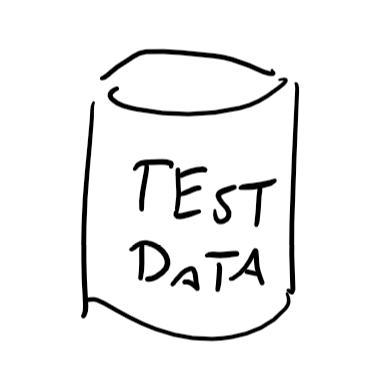

...and finally test the model with the test data set:

In [ ]:
#tehdaan rutiini, jolla voidaan hakea mika tahansa testiaineistocase "online" ja syottaa ko. tieto sitten analysoitavaksi...

testiaineiston_polku="../input/rsna-miccai-brain-tumor-radiogenomic-classification/test/"
tyyppi=("FLAIR", "T1w", "T1wCE", "T2w")

#huomaa etta tassa haetaan testi-id:t sample submission-puolelta...
testi_df = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv')

if prosessitesti==1:
    testi_id_luettelo=np.array(train_df["BraTS21ID"])[0:5]
else:
    testi_id_luettelo=np.array(train_df["BraTS21ID"])

#Määritellään silmukka, joka käy läpi yhden mittauksen kerrallaan...

testi_vaste=[]
testi_syote=[]

#luodaan tietorakenne, joka mahdollistaa tuloshistogrammin tulostuksen...
talle=[]

for id_numero in testi_id_luettelo:
    yhden_id_numeron_vastevektori=[]
    sekkari=time.time()
    for tyyppi_numero in range(4):
        try:
            inputdir=''.join([peruspolku,str(id_numero).zfill(5),"/",tyyppi[tyyppi_numero],"/"])
            #aika1=time.time()
            [maksimikohta_p,laskennallinen_puolivali_p,alkupuoli_p,loppupuoli_p]=analysoi_yhden_kansion_kuvapinon_piirteet(inputdir,0)
            #print("Hakuun kului...",time.time()-aika1," sekuntia")
    
            hakupolku=inputdir+maksimikohta_p
            maksimikohta_p_img=yhden_kuvan_kasittely(hakupolku,kuvakoko)
            
            hakupolku=inputdir+laskennallinen_puolivali_p
            laskennallinen_puolivali_p_img=yhden_kuvan_kasittely(hakupolku,kuvakoko)
            
            hakupolku=inputdir+alkupuoli_p
            alkupuoli_p_img=yhden_kuvan_kasittely(hakupolku,kuvakoko)
            
            hakupolku=inputdir+loppupuoli_p
            loppupuoli_p_img=yhden_kuvan_kasittely(hakupolku,kuvakoko)
            
            #huom! Ei tallenneta tietoa kumulatiivisesti, vaan pelkastaan vastearvot:
            
            if 0:
                #vaihtoehto on etta tehdaan oma kuva jokaisesta!
                testi_syote.append(maksimikohta_p_img)
                testi_syote.append(laskennallinen_puolivali_p_img)
                testi_syote.append(alkupuoli_p_img)
                testi_syote.append(alkupuoli_p_img)
               
                #ja jokaista vastaava vasteindeksi tallennetaan samalla vauhdilla...
                testi_vaste.append(vastearvo)
                testi_vaste.append(vastearvo)
                testi_vaste.append(vastearvo)
                testi_vaste.append(vastearvo)

            #mallin avulla kysytaan mika on vastearvo:
            #vastearvo=0.6+0.1*np.random.random()
            vastearvo=model.predict(np.expand_dims(testikuva,axis=0))
            #korvaa yllaoleva testattavalla mallilla!!!
                
            yhden_id_numeron_vastevektori.append(vastearvo)
            yhden_id_numeron_vastevektori.append(vastearvo)
            yhden_id_numeron_vastevektori.append(vastearvo)
            yhden_id_numeron_vastevektori.append(vastearvo)           
        
            if 0:
                plt.imshow(maksimikohta_p_img) #,cmap='gray', vmin=0, vmax=1)
                plt.title(''.join(["ID:n ",str(id_numero)," mittaus ",tyyppi[tyyppi_numero]," vaste: ",str(vastearvo)]))
                plt.draw()
                #print(np.max(isokuva))
                plt.pause(0.1)

            #print("ID-numeroa ",id_numero," mittaustyyppia ",tyyppinumero, " vastaava vastearvo: ",vastearvo)
        
        except:
            print("aineistossa puutteita!")
    
    print("Yhden henkilon tarkasteluun kului: ",time.time()-sekkari," sekuntia!")  
    
    #Tallennetaan tieto...
    talle.append(np.array(yhden_id_numeron_vastevektori))
    
    #jota tarkastelemalla (jatkossakin...) voidaan tehda fiksuja paatelmia siita, kumpaan luokkaan ko. mittaustulos kuuluu...
    
    
    #kun yksi henkilo on kayty lapi, tarkastellaan sen vastelukemien histogrammia...
    #kuva=plt.figure()
    #plt.hist(yhden_id_numeron_vastevektori)
    #plt.title(''.join(["ID ",str(id_numero)," vastejakauma, lkm:",str(len(yhden_id_numeron_vastevektori))]))
    #plt.draw()

    
print("...silmukka valmis!")

print("Submission-tiedoston laadinta...")

#joka tallennetaan submission-muotoon...
#HOX id-luettelo pitaa olla pitkassa string-muodossa...
testin_id_luettelo_s=[]
testitulos_vektori=[]
for i in range(len(testi_id_luettelo)):
    testin_id_luettelo_s.append(str(testi_id_luettelo[i]).zfill(5))                           
    #tahan tulee heuristiikkaa siita miten paatellaan talle[i] -vektorista etta kumpi tulos oikein on...
    #lopullinen_tulos=np.median(talle[i])'
    #katsotaan ihan aluksi vain keskiarvoa...ja sen mukaan paatos...
    lopullinen_tulos=np.mean(np.squeeze(talle[i]),axis=0)[1]
    testitulos_vektori.append(lopullinen_tulos)
    
    
submission = pd.DataFrame({"BraTS21ID": testin_id_luettelo_s, "MGMT_value": np.squeeze(testitulos_vektori)})
         
#lisaksi tarkasti oikealla nimella...
submission.to_csv("submission.csv", index=False)

#vasta lopuksi naytetaan kuvat...jos naytetaan...
plt.show()

print("********** kaikki valmista! ************")